In [1]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

from plotting import multiple_histograms_plot
from pipeline import LogFeaturesTransform
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMClassifier, plot_metric, plot_tree, create_tree_digraph
from auto_lgbm import find_n_estimators, grid_search

from sklearn.metrics import log_loss
from evaluation import predictions_hist, confusion_matrix_report, grid_search_report

import shap
import matplotlib.pyplot as plt
import math

import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)


C:\ProgramData\Anaconda3\envs\tera-out2018\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
print(df.Class.value_counts())
print()
print(df['Class'].mean()) 

0    284315
1       492
Name: Class, dtype: int64

0.00172748563062


In [4]:
y = df[['Class']]

In [5]:
x = df.drop(columns='Class')

In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.2, stratify=y, random_state=1)

In [7]:
ytrain.sum()

Class    394
dtype: int64

In [8]:
ytest.sum()

Class    98
dtype: int64

In [9]:
xtrain_true = xtrain[ytrain['Class'] == 1] 
xtrain_false = xtrain[ytrain['Class'] == 0]

In [10]:
xtrain_true.describe()

Time          V1          V2          V3          V4  \
count     394.000000  394.000000  394.000000  394.000000  394.000000   
mean    80499.611675   -4.613735    3.536156   -6.878303    4.468144   
std     48162.787760    6.608897    4.168226    6.963960    2.844114   
min       406.000000  -30.552380   -8.402154  -31.103685   -1.313275   
25%     41290.000000   -5.972454    1.134992   -8.606982    2.300244   
50%     74647.500000   -2.304607    2.679071   -5.050324    4.136683   
75%    128576.000000   -0.357602    4.904522   -2.093609    6.283622   
max    170348.000000    2.132386   22.057729    2.041003   11.927512   

               V5          V6          V7          V8          V9  \
count  394.000000  394.000000  394.000000  394.000000  394.000000   
mean    -3.018317   -1.406307   -5.330795    0.657250   -2.445369   
std      5.295959    1.916835    6.939668    6.902580    2.451831   
min    -22.105532   -6.406267  -43.557242  -41.044261  -13.434066   
25%     -4.758199   -2.559963   -7.801176   -0.135707   -3.828323   
50%     -1.402998   -1.424616   -2.843863    0.621508   -1.991845   
75%      0.320265   -0.357445   -0.898702    1.812047   -0.753221   
max     11.095089    6.474115    5.802537   20.007208    3.353525   

          ...              V20         V21         V22         V23  \
count     ...       394.000000  394.000000  394.000000  394.000000   
mean      ...         0.326114    0.825200   -0.020084   -0.063944   
std       ...         1.357058    3.886912    1.482234    1.688020   
min       ...        -4.128186  -22.797604   -8.887017  -19.254328   
25%       ...        -0.178603    0.098377   -0.521865   -0.349276   
50%       ...         0.270066    0.596733    0.049493   -0.080102   
75%       ...         0.817065    1.295662    0.615132    0.308483   
max       ...        11.059004   27.202839    8.361985    5.466230   

              V24         V25         V26         V27         V28       Amount  
count  394.000000  394.000000  394.000000  394.000000  394.000000   394.000000  
mean    -0.107400    0.056199    0.039361    0.198264    0.096053   123.349086  
std      0.520988    0.806648    0.467572    1.251943    0.533844   252.859298  
min     -2.028024   -4.781606   -1.152671   -7.263482   -1.869290     0.000000  
25%     -0.434334   -0.299993   -0.262623   -0.020917   -0.067442     1.000000  
50%     -0.061408    0.106593   -0.009778    0.386073    0.148218    10.495000  
75%      0.287740    0.481128    0.388845    0.797768    0.384480   105.620000  
max      1.091435    2.208209    2.745261    3.052358    1.779364  1809.680000  

[8 rows x 30 columns]

In [11]:
xtrain_false.describe()

Time             V1             V2             V3  \
count  227451.000000  227451.000000  227451.000000  227451.000000   
mean    94732.229364       0.007278      -0.007161       0.014476   
std     47518.510340       1.925116       1.622239       1.459825   
min         0.000000     -56.407510     -72.715728     -48.325589   
25%     54116.000000      -0.920264      -0.601080      -0.882790   
50%     84619.000000       0.018690       0.063001       0.183126   
75%    139273.000000       1.315650       0.798255       1.028862   
max    172792.000000       2.451888      18.902453       9.382558   

                  V4             V5             V6             V7  \
count  227451.000000  227451.000000  227451.000000  227451.000000   
mean       -0.003894       0.002367       0.004524       0.009256   
std         1.401090       1.361337       1.331251       1.186733   
min        -5.683171    -113.743307     -26.160506     -31.764946   
25%        -0.845815      -0.691651      -0.764770      -0.552959   
50%        -0.019510      -0.054424      -0.270864       0.040143   
75%         0.741542       0.611213       0.402013       0.569897   
max        16.715537      34.801666      73.301626     120.589494   

                  V8             V9      ...                  V20  \
count  227451.000000  227451.000000      ...        227451.000000   
mean       -0.001045       0.004479      ...            -0.001362   
std         1.166301       1.087899      ...             0.766427   
min       -73.216718      -6.290730      ...           -54.497720   
25%        -0.208346      -0.639557      ...            -0.212155   
50%         0.022345      -0.049892      ...            -0.062945   
75%         0.327020       0.597545      ...             0.132297   
max        18.709255      15.594995      ...            39.420904   

                 V21            V22            V23            V24  \
count  227451.000000  227451.000000  227451.000000  227451.000000   
mean       -0.001406       0.000934       0.000877      -0.000195   
std         0.715130       0.723361       0.613299       0.605862   
min       -34.830382     -10.933144     -36.666000      -2.836627   
25%        -0.228083      -0.541120      -0.162018      -0.354109   
50%        -0.029477       0.007580      -0.011120       0.041103   
75%         0.185868       0.529244       0.147692       0.438716   
max        22.599543      10.503090      22.083545       4.584549   

                 V25            V26            V27            V28  \
count  227451.000000  227451.000000  227451.000000  227451.000000   
mean        0.000039      -0.000369      -0.000389      -0.000193   
std         0.521554       0.482210       0.402095       0.330567   
min        -8.696627      -2.534330     -22.565679     -15.430084   
25%        -0.317501      -0.327644      -0.070772      -0.053007   
50%         0.016918      -0.052640       0.001249       0.011201   
75%         0.351194       0.240428       0.090556       0.078027   
max         7.519589       3.517346      31.612198      33.847808   

              Amount  
count  227451.000000  
mean       88.649291  
std       250.017768  
min         0.000000  
25%         5.610000  
50%        22.000000  
75%        77.760000  
max     25691.160000  

[8 rows x 30 columns]

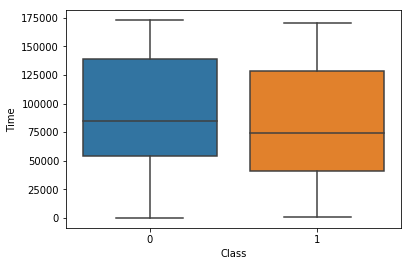

In [12]:
sns.boxplot(x=ytrain.Class,y=xtrain.Time)

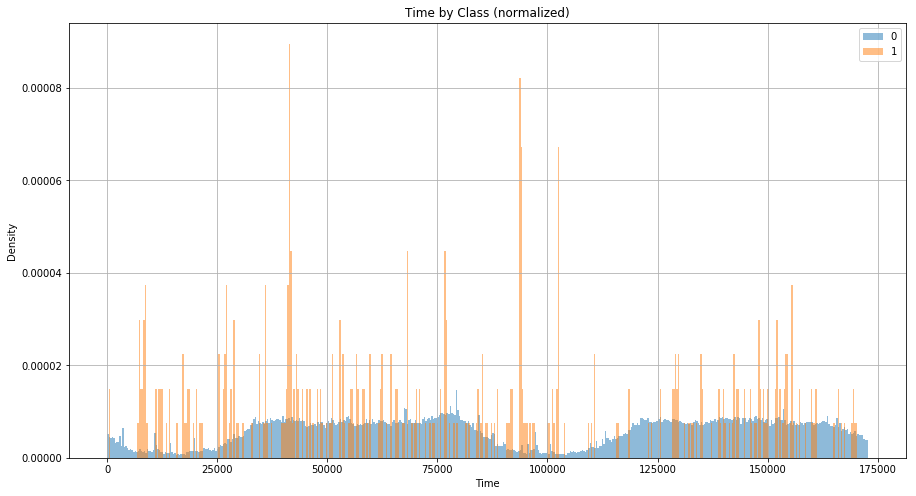

In [13]:
a= pd.concat([xtrain,ytrain], axis=1)

multiple_histograms_plot(data=a, x='Time', hue='Class', density=True, bins=500)

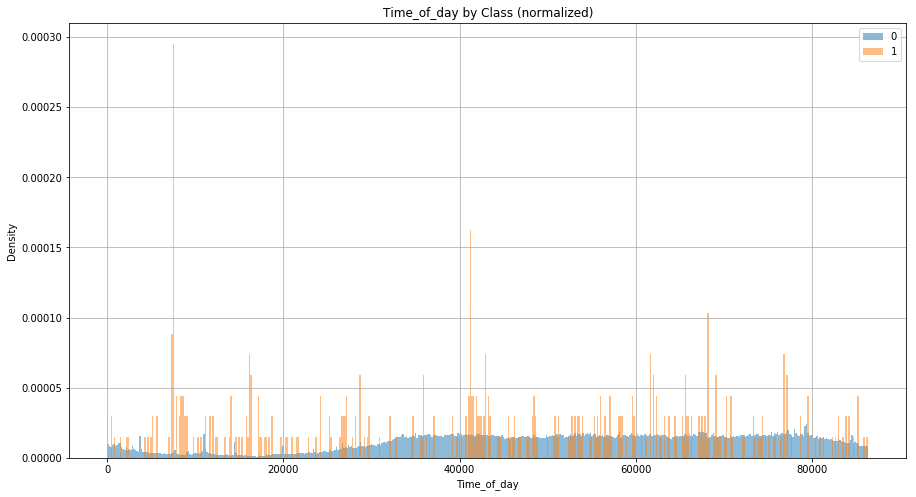

In [14]:
a['Time_of_day'] = a.Time.apply(lambda x: (x-86400) if x>86400 else x)

multiple_histograms_plot(data=a, x='Time_of_day', hue='Class', density=True, bins=500)

In [15]:
data = [go.Histogram(x=a['Time'], nbinsx=500)]

iplot(data, filename='histogram time')

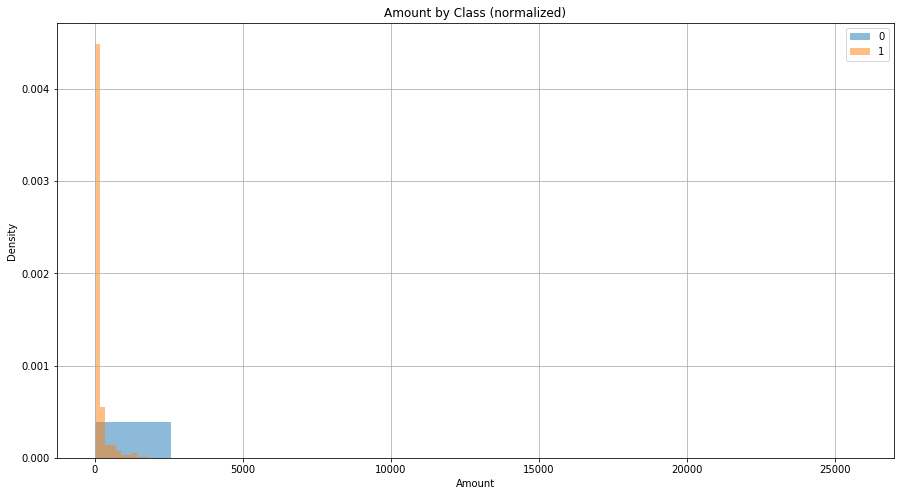

In [16]:
multiple_histograms_plot(data=a, x='Amount', hue='Class', density=True, bins=10)


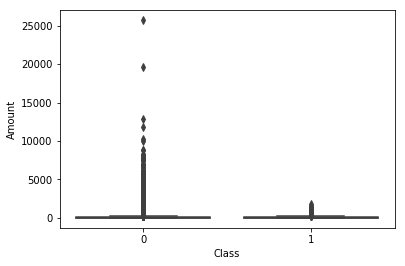

In [17]:
sns.boxplot(x=ytrain.Class,y=xtrain.Amount)

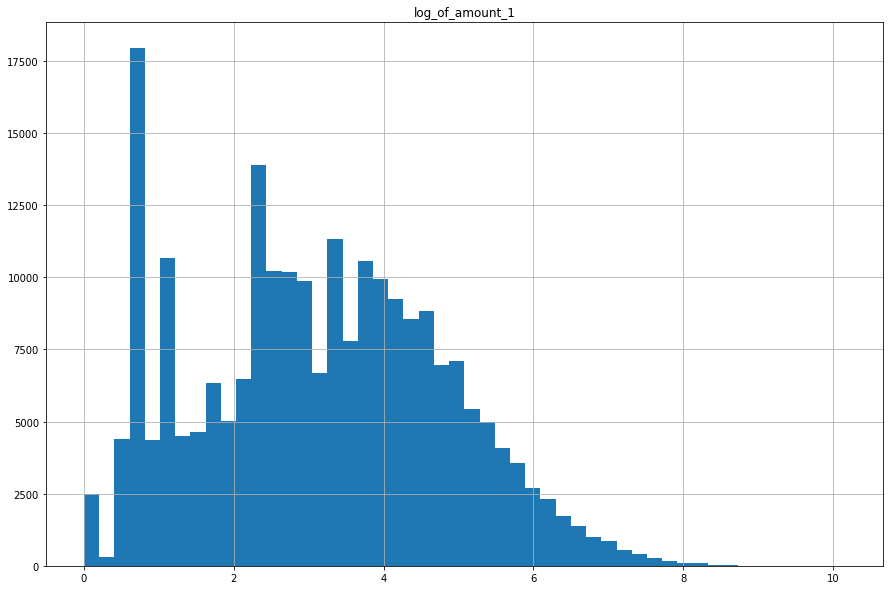

In [18]:
a = a.assign(amount_1=lambda x: x.Amount+1)
log_cols = ['amount_1']

a = LogFeaturesTransform(log_cols).fit_transform(a)

new_cols = [f"log_of_{c}" for c in log_cols]
_ = a[new_cols].hist(bins=50, figsize=(15,10))

In [19]:
a.log_of_amount_1.describe()

count    227845.000000
mean          3.154391
std           1.659342
min           0.000000
25%           1.879465
50%           3.135494
75%           4.368054
max          10.153941
Name: log_of_amount_1, dtype: float64

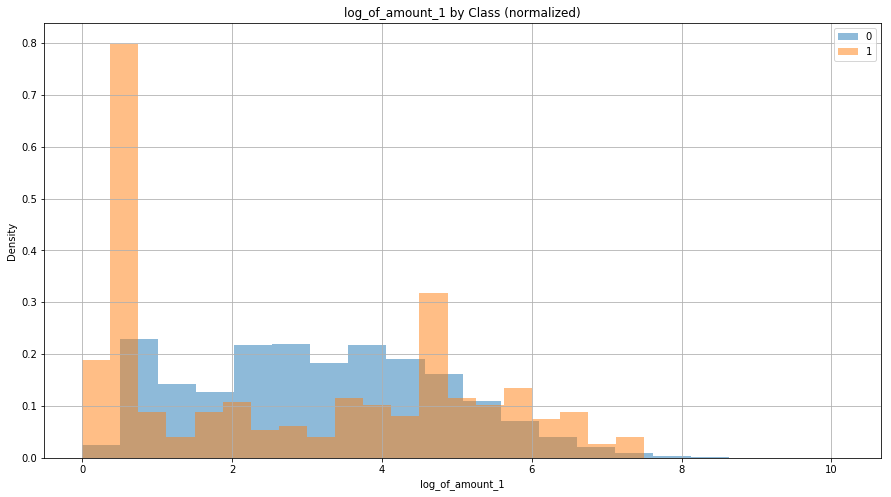

In [20]:
multiple_histograms_plot(data=a, x='log_of_amount_1', hue='Class', density=True, bins=20)

In [21]:
#Criar novas variaveis no banco original
#log
df = df.assign(amount_1=lambda x: x.Amount+1)
log_cols = ['amount_1']
df = LogFeaturesTransform(log_cols).fit_transform(df)

df['Time_of_day'] = df.Time.apply(lambda x: (x-86400) if x>86400 else x)


In [37]:
y = df[['Class']]

In [38]:
x = df.drop(columns='Class')

In [39]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(x)

x_scaled = pd.DataFrame(scaled_data, 
                        index=x.index,
                        columns=x.columns)


In [53]:
xtrain, xtest, ytrain, ytest = train_test_split(x_scaled,y, test_size=0.2, stratify=y, random_state=1)

## Regressão Logística

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             classification_report, roc_auc_score)

from plotting import (multiple_histograms_plot, plot_confusion_matrix, plot_roc)
from sklearn.externals import joblib

In [55]:
logreg = LogisticRegression()
logreg.fit(xtrain, ytrain)
y_pred = logreg.predict(xtest)

In [56]:
print(classification_report(ytest, y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.89      0.71      0.79        98

avg / total       1.00      1.00      1.00     56962



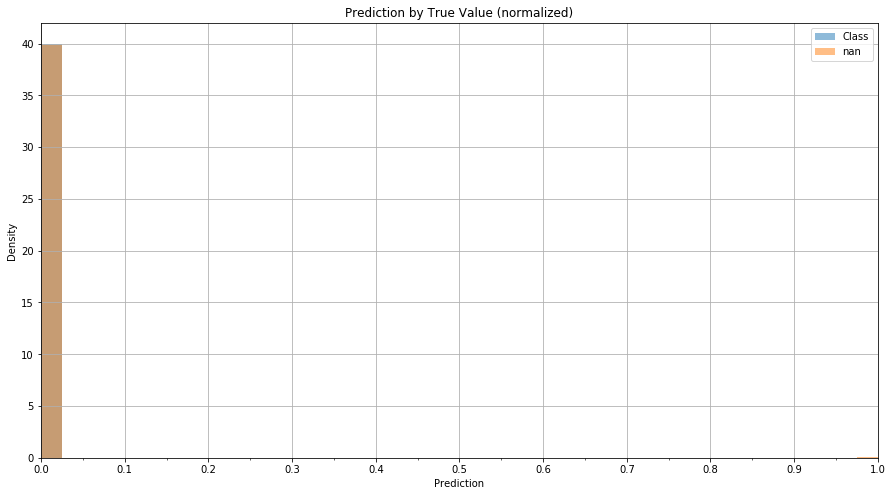

In [67]:
def predictions_hist(y_pred_proba, y_test, density=True):
    preds_df = pd.DataFrame(data=[y_pred_proba, y_test.astype(str)],
                            index=['Prediction', 'True Value']).T

    preds_df['Prediction'] = preds_df['Prediction'].astype(float)
    preds_df['True Value'] = preds_df['True Value'].astype(str)

    multiple_histograms_plot(data=preds_df, x='Prediction', hue='True Value',
                             bins=np.arange(0, 1.1, 0.025), density=density, probability_hist=True)

    return preds_df

y_pred_proba=logreg.predict_proba(xtest)
y_pred_proba = y_pred_proba[:, 1]

preds_df = predictions_hist(y_pred_proba, ytest)

In [69]:
preds_df['Predict Value'] = preds_df.Prediction.map(lambda x: x>0.1)

print(classification_report(ytest, preds_df['Predict Value']))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.80      0.84      0.82        98

avg / total       1.00      1.00      1.00     56962



             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.80      0.84      0.82        98

avg / total       1.00      1.00      1.00     56962



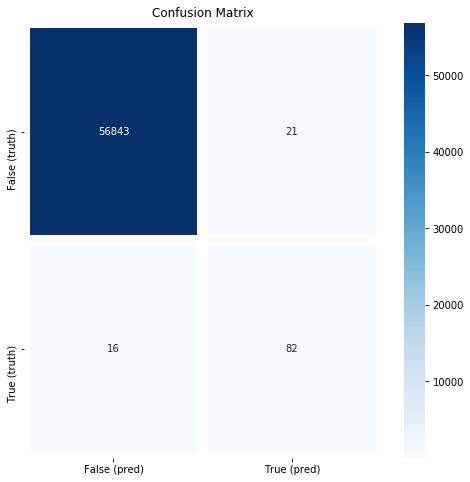

In [75]:
confusion_matrix_report(ytest, y_pred_proba, thres=0.1)

In [59]:
print(roc_auc_score(ytest, y_pred_proba))

0.979875542648


In [60]:
log_loss(ytest, y_pred_proba)

0.0032516058622870749

Vamos ver se dá para otimizar

In [61]:
logreg_cv = LogisticRegressionCV(scoring='roc_auc', class_weight='balanced',
                                 penalty='l2')

logreg_cv.fit(xtrain, ytrain)
logreg_cv.C_

y_pred_proba_regularization = logreg_cv.predict_proba(xtest)[:, 1]
y_pred_regul = logreg_cv.predict(xtest)


In [62]:
print('Classif', classification_report(ytest, y_pred_regul))
print('AUC', roc_auc_score(ytest, y_pred_proba_regularization))
print('log_loss', log_loss(ytest, y_pred_proba))

Classif              precision    recall  f1-score   support

          0       1.00      0.98      0.99     56864
          1       0.06      0.93      0.12        98

avg / total       1.00      0.98      0.99     56962

AUC 0.989301182628
log_loss 0.00325160586229


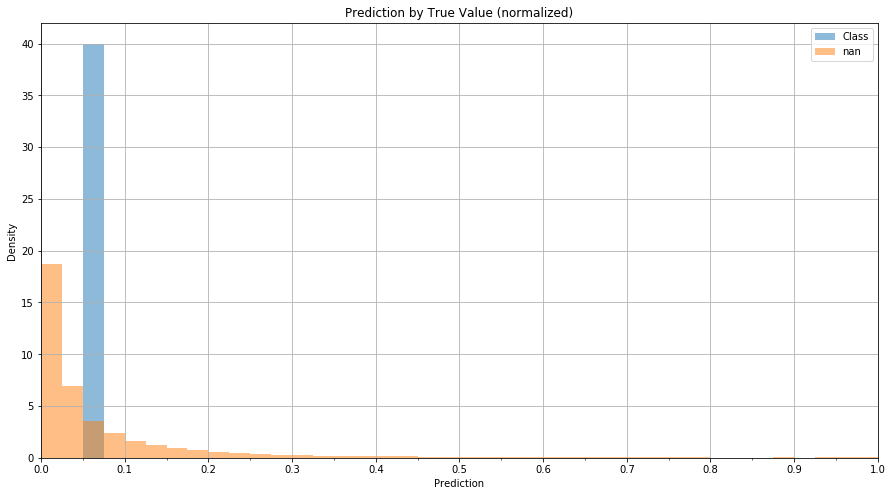

In [66]:
preds_df2 = predictions_hist(y_pred_proba_regularization, ytest)

## Gradient Boost

In [ ]:
lgbm = LGBMClassifier(class_weight='balanced', random_state=0)
lgbm.fit(xtrain, ytrain)